# Obtaining structured web content and programmatic access

In this notebook we will learn how to make use of readily structured data through dedicated application programming interfaces (APIs), how to authenticate and how to properly design requests (also called "payload") in order to retrieve large datasets.

**Advantages** of APIs are that
- access is legal and in most cases clearly and transparently regulated (e.g. 10,000 calls per day)
- structuring through `requests` and `BeautifulSoup` not required
- Python packages that simplify server-client interaction are available

**Disadvantages** of APIs are that
- we have to learn how APIs work and how we should interact with them (each API has some peculiarities and documentation is usually good, but sometimes not so...)
- authentification may be required and access may not be free of charge 

We will
- obtain data of a public statistical office such as the IMF or World Bank through the `pandas-datareader`
- directly obtain a (ranking) table from a website such the [World Cube Association](https://www.worldcubeassociation.org/results/rankings/333/single)
- learn how to use the Destatis/GENESIS Online service and API
- learn how to use the Twitter API (in particular [Tweepy](https://www.tweepy.org/), a Python library for the Twitter API) and retrieve Tweets with GeoTags (i.e. coordinates) subject to specified geography and search terms
- conduct some small analyses and visualise the results appropriately

In [1]:
import pandas as pd

In [2]:
!pip install pandas-datareader --upgrade

In [3]:
from pandas_datareader import wb # imports world bank access
search = wb.search('GDP.*current.*US') # search for keyword
search

,id,name,unit,source,sourceNote,sourceOrganization,topics
9217,NV.SRV.DISC.CD,"Discrepancy in GDP, value added (current US$)",,Africa Development Indicators,This is the discrepancy included in the value ...,"b'World Bank national accounts data, and OECD ...",
9345,NY.GDP.DISC.CD,Discrepancy in expenditure estimate of GDP (cu...,,Africa Development Indicators,This is the discrepancy included in the ‘total...,"b'World Bank national accounts data, and OECD ...",
9356,NY.GDP.MKTP.CD,GDP (current US$),,World Development Indicators,GDP at purchaser's prices is the sum of gross ...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9375,NY.GDP.PCAP.CD,GDP per capita (current US$),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9482,NYGDPMKTPSACD,"GDP,current US$,millions,seas. adj.,",,Global Economic Monitor,,b'',


In [4]:
df = wb.download(indicator = 'NY.GDP.MKTP.CD', country = ['DE', 'FR', 'IT'],
                start = 2000, end = 2019)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 60 entries, ('Germany', '2019') to ('Italy', '2000')
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NY.GDP.MKTP.CD  60 non-null     float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [5]:
df.groupby('country').describe()

NY.GDP.MKTP.CD                                            \
                 count          mean           std           min   
country                                                            
France            20.0  2.391444e+12  5.039285e+11  1.362249e+12   
Germany           20.0  3.213212e+12  6.554315e+11  1.943145e+12   
Italy             20.0  1.907346e+12  3.611625e+11  1.143830e+12   

                                                                 
                  25%           50%           75%           max  
country                                                          
France   2.176030e+12  2.618880e+12  2.733605e+12  2.918383e+12  
Germany  2.836649e+12  3.409510e+12  3.730707e+12  3.963768e+12  
Italy    1.827731e+12  1.982686e+12  2.145770e+12  2.398857e+12

In [6]:
df2 = df.reset_index()
df2.head()

,country,year,NY.GDP.MKTP.CD
0,Germany,2019,3.861124e+12
1,Germany,2018,3.963768e+12
2,Germany,2017,3.682602e+12
3,Germany,2016,3.467498e+12
4,Germany,2015,3.356236e+12


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         60 non-null     object 
 1   year            60 non-null     object 
 2   NY.GDP.MKTP.CD  60 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


In [8]:
df2.columns = ['country', 'year', 'gdp'] # rename columns
df2.year = df2.year.astype(int) # numeric annual indicator
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  60 non-null     object 
 1   year     60 non-null     int32  
 2   gdp      60 non-null     float64
dtypes: float64(1), int32(1), object(1)
memory usage: 1.3+ KB


In [9]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
# set(df2['country'])

In [10]:
traces = []

for country in df2['country'].unique():
    
    trace = go.Scatter(name = country, x = df2[df2['country'] == country]['year'],
                      y = df2[df2['country'] == country]['gdp'])
    
    traces.append(trace)
    
fig = go.Figure(data = traces)

fig.layout.update(title=go.layout.Title(

    text = 'Nominal GDP'

))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in US$')));

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'Nominal_GDP')

## Directly parsing `table` objects from HTML

In [79]:
ranking = pd.read_html('https://www.worldcubeassociation.org/results/rankings/333/single', encoding='utf-8')

In [80]:
ranking[0].head()

,#,Name,Result,Citizen of,Competition,Unnamed: 5
0,1,Yusheng Du (杜宇生),3.47,China,Wuhu Open 2018,NaN
1,2,Feliks Zemdegs,4.16,Australia,Auckland Summer Open 2020,NaN
2,3,Patrick Ponce,4.24,United States,Northeast Championship 2019,NaN
3,4,Nicolás Sánchez,4.38,United States,GA Cubers Feet Fest 2019,NaN
4,5,Max Park,4.40,United States,SacCubing V 2018,NaN


Which nationality appears most frequently in the World Cube Association's ranking?

In [81]:
ranking[0].groupby('Citizen of').count()

,#,Name,Result,Competition,Unnamed: 5
Citizen of,,,,,
Argentina,1,1,1,1,0
Australia,4,4,4,4,0
Canada,4,4,4,4,0
China,11,11,11,11,0
Czech Republic,1,1,1,1,0
Denmark,2,2,2,2,0
Finland,1,1,1,1,0
France,4,4,4,4,0
Germany,5,5,5,5,0


Which nationality needed, on average, the **lowest** amount of time to solve a 3x3x3 cube? Sort the output in ascending order.

In [82]:
ranking[0].groupby('Citizen of').mean()['Result'].sort_values(ascending = True)

Citizen of
Poland               4.740000
Netherlands          4.740000
Finland              4.800000
Japan                4.800000
Mongolia             4.840000
Republic of Korea    4.878000
Australia            4.895000
India                4.910000
Germany              4.940000
France               4.940000
Czech Republic       4.970000
United Kingdom       5.000000
China                5.010000
Malaysia             5.020000
Denmark              5.045000
Philippines          5.077500
United States        5.118065
Canada               5.172500
Greece               5.220000
Ukraine              5.340000
Taiwan               5.345000
Spain                5.373333
Russia               5.405000
Indonesia            5.470000
Singapore            5.500000
Argentina            5.500000
Thailand             5.505000
Peru                 5.520000
Hong Kong            5.520000
Sweden               5.520000
Norway               5.540000
Name: Result, dtype: float64

How many possible states/permutations, starting from the solved state, can a 3x3x3 Rubik's cube have? 

Hints:
1. The centre squares are fixed (a plane rotation around these squares doesn't change the cube's state)
2. There are eight corner pieces (with three colors on the side) and twelve edge pieces (with two colors on the side) which all revolve around the centre pieces
3. There are six different colors
4. We only look at "legal" states, i.e. those that can only be realised without assembling the cube (and therefore not violating Hint 1)

In [35]:
import math

answer = (math.factorial(8) * 3**8) * 1/3 * (math.factorial(12) * 2**12) * 1/2 * 1/2

# [(corner pieces) * fraction of admissible corner combinations (clock-wise and anti-clockwise twists cancel each other out, 
# hence 3**7 / 3**8 = 1/3)] 
# * [(edge pieces) * fraction of admissible edge combinations (clock-wise and anti-clockwise twists cancel each other out, 
# hence 2**11 / 2**12 = 1/2)]
# * [1/2 (only half of the corner and edge states can be reached as corner and edge states must both coincide in the number
# i.e. even or odd of turns taken to reach either position)]

print(str(answer) + " or about 43.2 quintillion combinations!")

4.325200327448986e+19 or about 43.2 quintillion combinations!


Which result entry in the World Ranking table is the most recent one? Which one is the oldest one? Be as precise as possible! (Hint: You may have to combine your knowledge from scraping HTML files.)

Compute the expected value of `Result` conditional on `Nationality = 'Germany'`. Are the German contestants statistically significantly faster/slower in solving the cube than other contestants, based on `Nationality`? Does statistical significance change if you use robust standard errors?

In [48]:
!pip install statsmodels

  Using cached patsy-0.5.1-py2.py3-none-any.whl (231 kB)


In [49]:
import statsmodels.api as sm

In [83]:
df = ranking[0]
df['Non_German_Dummy'] = 1

In [84]:
non_german_index = df[df['Citizen of'] != 'Germany'].index

In [ ]:
german_index = [x for x in df.index if x not in non_german_index]

In [89]:
dummy_values = [0 if y in german_index else 1 for y in df.index]

In [92]:
X = dummy_values
Y = df['Result']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Result   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9052
Date:                Sat, 10 Apr 2021   Prob (F-statistic):              0.344
Time:                        15:15:47   Log-Likelihood:                -42.916
No. Observations:                 100   AIC:                             89.83
Df Residuals:                      98   BIC:                             95.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9400      0.168     29.423      0.0

In [94]:
model.get_robustcov_results(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Result   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     2.496
Date:                Sat, 10 Apr 2021   Prob (F-statistic):              0.117
Time:                        15:21:43   Log-Likelihood:                -42.916
No. Observations:                 100   AIC:                             89.83
Df Residuals:                      98   BIC:                             95.04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9400      0.096     51.435      0.000       4.749       5.131
x1             0.1639      0.104      1.580      0.117      -0.042       0.370
==============================================================================
Omnibus:                       29.241   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.330
Skew:                          -1.221   Prob(JB):                     7.14e-12
Kurtosis:                       5.522   Cond. No.                         8.83
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

## Spatial libraries

The installation procedure of spatial libraries for Python (on Windows) can be quite tedious but [this answer](https://stackoverflow.com/questions/51095970/install-python-geopandas-failed/51560940#51560940) on Stackoverflow (make sure to upvote ;)) and [this detailed instruction](https://geoffboeing.com/2014/09/using-geopandas-windows/) make it straight forward. You can also find the required wheels for Python 3.8 and 64-bit for offline `pip install` in this notebook's [repository](https://github.com/gerwolf/webscraping-workshop/tree/main/DataFrames%20and%20APIs). After this, you can simply `pip install geopandas`.

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [96]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

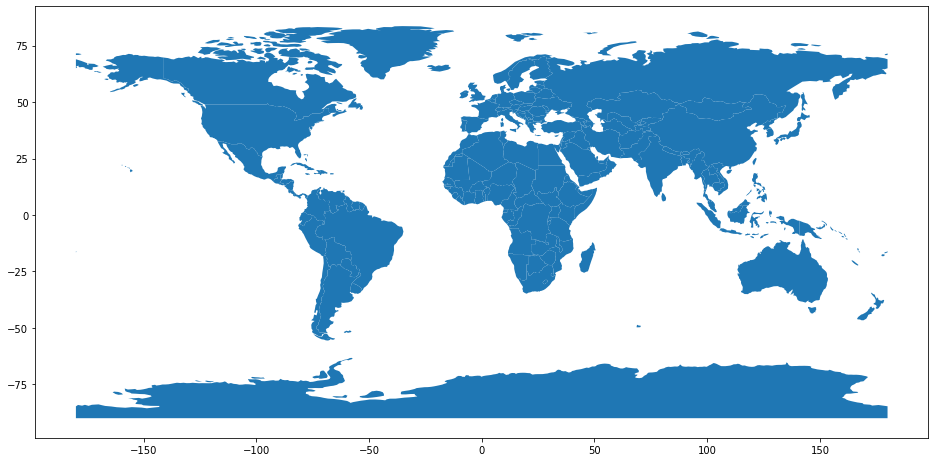

In [97]:
world.plot()

In [98]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [99]:
df = pd.read_csv("https://gist.githubusercontent.com/gerwolf/81ebb170eb25d4a13f2695db4520f90e/raw/7c24eb4a2b11f6d4c7ac38bdf3555dfc7da6823e/GDPpc_PPP.csv", sep = ";")
df['Country'] = df['Country'].str.replace('�',' ')
df['Country'] = df['Country'].str.replace('United States','United States of America')

In [100]:
df[df['Country'] == 'United States of America']

,Country,GDPpc_PPP
11,United States of America,"62,606"


In [101]:
final_geodf = df.merge(world, left_on='Country', right_on = 'name', how = 'left').dropna()

In [102]:
final_geodf['GDPpc_PPP'] = final_geodf['GDPpc_PPP'].str.replace(',','')

In [103]:
fig = go.Figure(data=[go.Choropleth(
    locations=final_geodf['iso_a3'], # Spatial coordinates
    z = final_geodf['GDPpc_PPP'].astype(float), # Data to be color-coded
#     locationmode = 'world', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=final_geodf['Country']
#     colorbar_title = "Millions USD",
)])

fig.layout.update(
    title_text = 'GDP per capita (2018, IMF)',
    geo_scope='world', # limite map scope to USA
);

iplot(fig, filename ="geomap")

In [104]:
fig = go.Figure(data=[go.Choropleth(
    locations=final_geodf[final_geodf['continent'] == 'Europe']['iso_a3'], # Spatial coordinates
    z = final_geodf[final_geodf['continent'] == 'Europe']['GDPpc_PPP'].astype(float), # Data to be color-coded
#     locationmode = 'world', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=final_geodf[final_geodf['continent'] == 'Europe']['Country']
#     colorbar_title = "Millions USD",
)])

fig.layout.update(
    title_text = 'GDP per capita (2018, IMF)',
    geo_scope='europe', # limite map scope to USA
);

iplot(fig, filename ="geomap")

## Destatis/GENESIS Online
The GENESIS API is the web interface service by the Federal Statistical Office of Germany and is a good place to start learning how to interact programmatically with a server.

There is a [comprehensive description/introduction](https://www-genesis.destatis.de/genesis/misc/GENESIS-Webservices_Einfuehrung.pdf) on the service, unfortunately in German only. To display the PDF inside Jupyter Notebook in Chrome you may have to enable the [PDF Viewer extension](https://chrome.google.com/webstore/detail/pdf-viewer/oemmndcbldboiebfnladdacbdfmadadm?utm_source=chrome-ntp-icon).

In [113]:
from IPython.display import IFrame, display
filepath = "https://www-genesis.destatis.de/genesis/misc/GENESIS-Webservices_Einfuehrung.pdf"
IFrame(filepath, width=980, height=800)

Read about the `whoami` method (in Section 2.2). Do you have to authenticate? What does it return? How would you send a `request`?

In [115]:
import genesis_config
import requests

In [123]:
url = "https://www-genesis.destatis.de/genesisWS/rest/2020/helloworld/whoami"
response = requests.get(url)
response.text

'{"User-Agent":"python-requests/2.25.1","User-IP":"95.91.213.125"}'

Read about the `logincheck` method (in Section 2.2). Do you have to authenticate? What does it return? Construct a request object using string formatting, send a `request` (in English language) and print the request's status. What type is the response's `text` attribute?

In [137]:
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/helloworld/logincheck?username={}&password={}&language={}'.format(genesis_config.Username, genesis_config.Password, 'en')
response = requests.get(url)

In [138]:
print(response.text)

{"Status":"You have been logged in and out successfully!","Username":"DE56JNILRL"}


Now that we have a working connection to the GENESIS Online API we want to directly obtain an economic indicator, the private sector's savings rate on a quarterly basis, for instance. This `data` is usually stored in a `table` somewhere in the depths of a data warehouse and it is (unfortunately) necessary to familiarise yourself, at least partially, with the internal server's structure.
1. In the documentation file search for the `tablefile` method (under Section 2.5 Data). When should it be used? What does it return?
2. Which method should you use if you want to directly obtain a `chart`?
3. Which method should you use if you want to directly obtain a regional `map`? Which parameter controls the image's resolution?

In [200]:
field = '12411-0010'
stand = '31.12.2019'
language = 'en'
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/data/map2table?username={}&password={}&name={}&area=all&mapType=0&classes=5&classification=0&zoom=3&startyear=&endyear=&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1=&classifyingkey1=&classifyingvariable2=&classifyingkey2=&classifyingvariable3=&classifyingkey3=&format=png&stand={}&language={}'.format(genesis_config.Username, genesis_config.Password, field, stand, language)
response = requests.get(url)

In [201]:
with open("map.png", 'wb') as f:
    f.write(response.content)

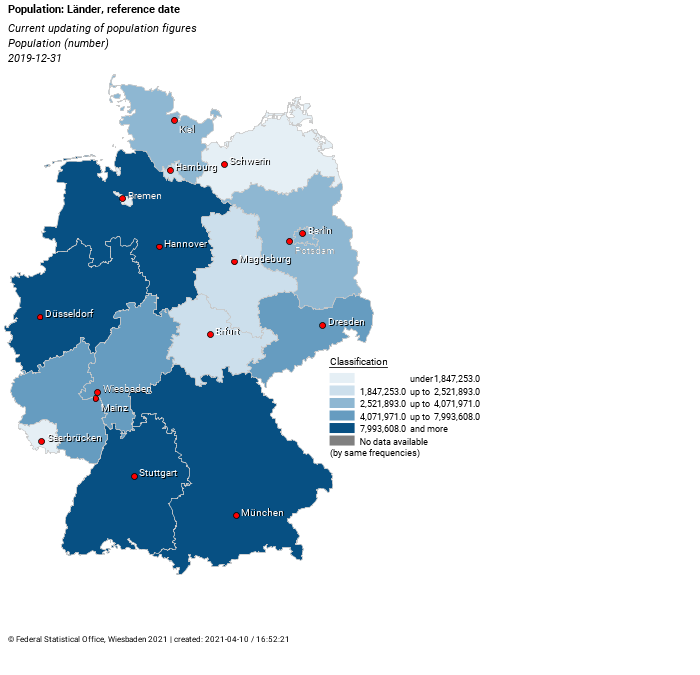

In [202]:
from IPython.display import Image
Image(filename='map.png') 

4. Login to the [GENESIS Online user interface](https://www-genesis.destatis.de/genesis/online?Menu=Anmeldung#abreadcrumb). Familiarise yourself with the tables' structure and navigate to the National Accounts (at the central level) --> Private sector disposable income and savings at quarterly frequency. Which parameters in the request can you control?
5. Which method would you choose if you want to directly obtain a `table` in some machine readable format, e.g. a `.csv` or `.xlsx` that you can read into `pandas`? How do you include additional conditions matching particular values?
6. Construct a `request` which contains the following specification:
    - only seasonally and calendar-adjusted values (X13)
    - all available years and quarters
    - output format should be a `.xlsx` file
7. Send the request but directly through the `pandas.read_excel()` method.

In [207]:
! pip install openpyxl

  Using cached et_xmlfile-1.0.1.tar.gz (8.4 kB)
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=fa96cea2e482c572fa1b2540ccf7d37e759f8f790b7ebd54e1aa4dd19463ebea
  Stored in directory: c:\users\wolfg\appdata\local\pip\cache\wheels\6e\df\38\abda47b884e3e25f9f9b6430e5ce44c47670758a50c0c51759
Successfully built et-xmlfile


In [238]:
code = '81000-0010'
key_1 = 'WERT04'
val_1 = 'X13JDKSB'
key_2 = ''
val_2 = ''
key_3 = ''
val_3 = ''
start_year = '1991'
end_year = '2020'

url = ('https://www-genesis.destatis.de/genesisWS/rest/2020/data/tablefile?username={}&password={}&name={}&area=DINSG*&compress=false&transpose=false&startyear={}&endyear={}&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1={}&classifyingkey1={}&classifyingvariable2={}&classifyingkey2={}&classifyingvariable3={}&classifyingkey3={}&format=xlsx&job=false&stand=&language=de').format(genesis_config.Username, genesis_config.Password, code, start_year, end_year, key_1, val_1, key_2, val_2, key_3, val_3)
df = pd.read_excel(url)

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [239]:
df

,"VGR des Bundes - Verfügbares Einkommen, Sparen der privaten Haushalte: Deutschland, Quartale, Original- und bereinigte Daten",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121
0,Volkswirtschaftliche Gesamtrechnungen des Bundes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Deutschland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gegenstand der Nachweisung,Einheit,1991,NaN,NaN,NaN,1992,NaN,NaN,NaN,...,NaN,NaN,2019,NaN,NaN,NaN,2020,NaN,NaN,NaN
3,NaN,NaN,1. Quartal,2. Quartal,3. Quartal,4. Quartal,1. Quartal,2. Quartal,3. Quartal,4. Quartal,...,3. Quartal,4. Quartal,1. Quartal,2. Quartal,3. Quartal,4. Quartal,1. Quartal,2. Quartal,3. Quartal,4. Quartal
4,Originalwerte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arbeitnehmerentgelt (Inländer),Mrd. EUR,190.197,206.154,212.991,246.469,208.779,220.8,233.986,264.171,...,438.034,487.441,432.29,451.739,457.625,504.284,445.118,437.17,455.087,503.991
6,- Sozialbeiträge der Arbeitgeber,Mrd. EUR,33.698,37.577,37.874,43.341,37.712,39.515,41.479,46.84,...,76.152,84.304,76.969,80.176,79.488,87.672,79.505,82.147,81.002,89.278
7,= Bruttolöhne und -gehälter (Inländer),Mrd. EUR,156.499,168.577,175.117,203.128,171.067,181.285,192.507,217.331,...,361.882,403.137,355.321,371.563,378.137,416.612,365.613,355.023,374.085,414.713
8,- Abzüge der Arbeitnehmer,Mrd. EUR,42.587,51.168,51.608,65.183,51.255,57.642,57.679,69.453,...,115.362,134.415,116.338,127.828,118.988,138.173,119.88,120.793,115.758,135.828
9,= Nettolöhne u. -gehälter (Inländer),Mrd. EUR,113.912,117.409,123.509,137.945,119.812,123.643,134.828,147.878,...,246.52,268.722,238.983,243.735,259.149,278.439,245.733,234.23,258.327,278.885


In [240]:
import numpy as np

In [241]:
df = df.iloc[[2,3,37], :].T.iloc[2:,:]
df.columns = ['Year', 'Quarter', 'Rate']
df.reset_index(inplace = True, drop = True)
df['Year'] = df['Year'].fillna(method='ffill')
df['Quarter_str'] = df['Quarter'].copy()
df['Quarter'] = df['Quarter'].replace('1. Quartal', 'Q1')
df['Quarter'] = df['Quarter'].replace('2. Quartal', 'Q2')
df['Quarter'] = df['Quarter'].replace('3. Quartal', 'Q3')
df['Quarter'] = df['Quarter'].replace('4. Quartal', 'Q4')
df['Rate'] = df['Rate'].replace ('...', np.NaN)
qs = df['Year'] + '-' + df['Quarter']
df['Date'] = pd.PeriodIndex(qs.values, freq='Q').to_timestamp()
df.set_index(df['Date'], inplace = True, drop = True)
del df['Date']
df.dropna(inplace=True)
df['col_name'] = df['Quarter'] + ' ' + df['Year'].str[2:4]
col_names = list(df['col_name'].values)
df = df.T
df.columns = col_names
df = df.T

In [243]:
df.head()

,Year,Quarter,Rate,Quarter_str,col_name
Q1 91,1991,Q1,12.6,1. Quartal,Q1 91
Q2 91,1991,Q2,13.6,2. Quartal,Q2 91
Q3 91,1991,Q3,12.7,3. Quartal,Q3 91
Q4 91,1991,Q4,12.7,4. Quartal,Q4 91
Q1 92,1992,Q1,12.9,1. Quartal,Q1 92


In [244]:
fig = go.Figure(data=[
    
    go.Scatter(name='Private sector savings rate', x = list(df.index),
    y = list(df['Rate']))
    
])

fig.layout.update(title = go.layout.Title(
                        text='Private sector savings rate (Germany)'))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in % of disposable income')))

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Quarter-Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'savings_rate')